# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, split_dataset, preprocess_dataset, EarlyStopper

# load simplified.csv into df
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

label_encoder = preprocessing.LabelEncoder()

df['label'] = label_encoder.fit_transform(df['label'])
X = df.drop(['filename', 'label'], axis=1)
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}

    # for each batch size, create the dataset and add it into the 4 dictionaries declared above.
    # Retrieve index from k-fold and extract the matrix / list from X_train and y_train.
    # Preprocess x_train and x_validation and store it in the dictionaries above.
    for batch in range(len(parameters)):
        # Getting my function ready? I am assuming this is the function
        # cv = KFold(n_splits=5, shuffle=True, random_state=batch)
        cv = KFold(n_splits=5, shuffle=False)

        # Declaring a list to store my folds for features
        X_train_scaled_dict[parameters[batch]], X_val_scaled_dict[parameters[batch]] = [], []

        # Declaring a list to store my folds for labels
        y_train_dict[parameters[batch]], y_val_dict[parameters[batch]] = [], []

        # for loop to store my datasets in dictionary for each batch size
        for train_idx, val_idx in cv.split(X_train, y_train):
            # print(f"batch: {parameters[batch]}\ttrain_idx: {train_idx.shape}\tval_idx: {val_idx.shape}")
            # Extracting x_train and x_val
            pre_x_train = X_train[train_idx]
            pre_x_val = X_train[val_idx]

            # Adding each fold's labels into y_train and y_val dictionary
            y_train_dict[parameters[batch]].append(y_train[train_idx])
            y_val_dict[parameters[batch]].append(y_train[val_idx])

            # Scaling my input features
            processed_X_train, processed_x_val = preprocess_dataset(pre_x_train, pre_x_val)

            # Adding each fold's input features into x_train and x_val dictionary
            X_train_scaled_dict[parameters[batch]].append(processed_X_train)
            X_val_scaled_dict[parameters[batch]].append(processed_x_val)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


In [4]:
print(f"X_train_scaled_dict")
for key, val in X_train_scaled_dict.items():
    print(f"Key: {key}:\tNumber of folds: {len(val)}")
    print(f"Input Feature shape: {[fold.shape for fold in val]}")


X_train_scaled_dict
Key: 128:	Number of folds: 5
Input Feature shape: [(6751, 77), (6751, 77), (6751, 77), (6751, 77), (6752, 77)]
Key: 256:	Number of folds: 5
Input Feature shape: [(6751, 77), (6751, 77), (6751, 77), (6751, 77), (6752, 77)]
Key: 512:	Number of folds: 5
Input Feature shape: [(6751, 77), (6751, 77), (6751, 77), (6751, 77), (6752, 77)]
Key: 1024:	Number of folds: 5
Input Feature shape: [(6751, 77), (6751, 77), (6751, 77), (6751, 77), (6752, 77)]


In [5]:
print(f"y_train_dict")
for key, val in y_train_dict.items():
    print(f"Key: {key}:\tNumber of folds: {len(val)}")
    print(f"Input Feature shape: {[fold.shape for fold in val]}")

y_train_dict
Key: 128:	Number of folds: 5
Input Feature shape: [(6751,), (6751,), (6751,), (6751,), (6752,)]
Key: 256:	Number of folds: 5
Input Feature shape: [(6751,), (6751,), (6751,), (6751,), (6752,)]
Key: 512:	Number of folds: 5
Input Feature shape: [(6751,), (6751,), (6751,), (6751,), (6752,)]
Key: 1024:	Number of folds: 5
Input Feature shape: [(6751,), (6751,), (6751,), (6751,), (6752,)]


In [6]:
print(f"X_val_scaled_dict")
for key, val in X_val_scaled_dict.items():
    print(f"Key: {key}:\tNumber of folds: {len(val)}")
    print(f"Input Feature shape: {[fold.shape for fold in val]}")

X_val_scaled_dict
Key: 128:	Number of folds: 5
Input Feature shape: [(1688, 77), (1688, 77), (1688, 77), (1688, 77), (1687, 77)]
Key: 256:	Number of folds: 5
Input Feature shape: [(1688, 77), (1688, 77), (1688, 77), (1688, 77), (1687, 77)]
Key: 512:	Number of folds: 5
Input Feature shape: [(1688, 77), (1688, 77), (1688, 77), (1688, 77), (1687, 77)]
Key: 1024:	Number of folds: 5
Input Feature shape: [(1688, 77), (1688, 77), (1688, 77), (1688, 77), (1687, 77)]


In [7]:
print(f"y_val_dict")
for key, val in y_val_dict.items():
    print(f"Key: {key}:\tNumber of folds: {len(val)}")
    print(f"Input Feature shape: {[fold.shape for fold in val]}")

y_val_dict
Key: 128:	Number of folds: 5
Input Feature shape: [(1688,), (1688,), (1688,), (1688,), (1687,)]
Key: 256:	Number of folds: 5
Input Feature shape: [(1688,), (1688,), (1688,), (1688,), (1687,)]
Key: 512:	Number of folds: 5
Input Feature shape: [(1688,), (1688,), (1688,), (1688,), (1687,)]
Key: 1024:	Number of folds: 5
Input Feature shape: [(1688,), (1688,), (1688,), (1688,), (1687,)]


In [8]:
def dataloader_maker(mini_x, mini_y, batch_size, shuffle):
    """
    This function is to take the x_train / x_val and y_train / y_val and convert it to a DataLoader object with its batch sizes.
    """
    data = CustomDataset(mini_x, mini_y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def train_loop(dataloader, model, loss_fn, optimizer):
    """
    This function is used find the training loss and accuracy of each fold for each batch size.
    Will return the training loss of each fold for each batch size.
    Will return the accuracy for each fold per batch size.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # print(f"Training: Number of batches: {num_batches}\tDataset size: {size}")
    train_loss, acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= size
    acc /= size
    return train_loss, acc

def val_loop(dataloader, model, loss_fn):
    """
    This function is used to find the validation loss and accuracy of each fold for each batch size.
    Will return the validation loss for validation.
    Will return the accuracy for validation.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # print(f"Validation: Number of batches: {num_batches}\tDataset size: {size}")
    val_loss, acc = 0, 0
    with torch.no_grad():
        for x, y, in dataloader:
            pred = model(x)

            val_loss += loss_fn(pred, y).item()
            acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= size
    acc /= size
    return val_loss, acc

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [9]:

# YOUR CODE HERE
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, title):
    no_features = 77
    no_hidden = 128
    no_labels = 2
    lr = 0.001
    no_epochs = 100
    cv_acc = []
    cv_time = []
    for batch in range(len(batch_sizes)):
        print(f"{title}: {batch_sizes[batch]}")
        cv_acc_per_fold = []
        cv_time_per_fold = []
        for fold in range(5): # Fold index
            print(f"\tFold: {fold}")
            x_train = X_train_scaled_dict[batch_sizes[batch]][fold]
            x_val   = X_val_scaled_dict[batch_sizes[batch]][fold]
            y_train = y_train_dict[batch_sizes[batch]][fold]
            y_val   = y_val_dict[batch_sizes[batch]][fold]

            train_dataloader = dataloader_maker(x_train, y_train, batch_sizes[batch], True)
            val_dataloader = dataloader_maker(x_val, y_val, batch_sizes[batch], True)

            # Modified class parameters to accomodate for part A3 issue of 2 different number of neurons
            model = MLP(no_features, no_hidden, no_labels)
            # loss_fn alr imported from common_utils
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

            train_loss, val_loss = [], []
            train_acc_per_fold, val_acc_per_fold = [], []
            train_time_taken_per_fold, val_time_taken_per_fold = [], []
            for epoch in range(no_epochs):
                start = time.time()

                # Training
                train_loss_, train_acc_ = train_loop(train_dataloader, model, loss_fn, optimizer)
                val_loss_, val_acc_ = val_loop(val_dataloader, model, loss_fn)

                # Storing training and validation loss per fold per batch size
                train_loss.append(train_loss_), val_loss.append(val_loss_)

                # Storing training and validation accuracy per fold per batch size
                train_acc_per_fold.append(train_acc_), val_acc_per_fold.append(val_acc_)

                train_time_ = time.time() - start
                train_time_taken_per_fold.append(train_time_)

                if early_stopper.early_stop(val_loss_):
                    print(f"Early Stopping at epoch {epoch}!")
                    break
            # Store last epoch validation accuracy of each fold per batch size
            cv_acc_per_fold.append(val_acc_per_fold[-1])
            # cv_acc.append(np.mean(val_acc_per_fold))

            # Store last epoch's training time of each fold per batch size
            cv_time_per_fold.append(train_time_taken_per_fold[-1])

            print(f"\tLast Epoch Validation Accuracy: {cv_acc_per_fold[-1]}")
            print(f"\tLast Epoch Time taken: {cv_time_per_fold[-1]}")
        cv_acc.append(np.mean(cv_acc_per_fold))
        cv_time.append(cv_time_per_fold)
        print(f"CV_acc:\n{cv_acc}")
        print(f"CV_time:\n{cv_time}")

    return cv_acc, cv_time

# batch_sizes = []
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


batch_size: 128
	Fold: 0
Early Stopping at epoch 16!
	Last Epoch Validation Accuracy: 0.6771327014218009
	Last Epoch Time taken: 0.644902229309082
	Fold: 1
Early Stopping at epoch 18!
	Last Epoch Validation Accuracy: 0.6812796208530806
	Last Epoch Time taken: 0.2955594062805176
	Fold: 2
Early Stopping at epoch 23!
	Last Epoch Validation Accuracy: 0.6966824644549763
	Last Epoch Time taken: 0.294252872467041
	Fold: 3
Early Stopping at epoch 23!
	Last Epoch Validation Accuracy: 0.691350710900474
	Last Epoch Time taken: 0.2893073558807373
	Fold: 4
Early Stopping at epoch 20!
	Last Epoch Validation Accuracy: 0.6834617664493183
	Last Epoch Time taken: 0.29224371910095215
CV_acc:
[0.6859814528159299]
CV_time:
[[0.644902229309082, 0.2955594062805176, 0.294252872467041, 0.2893073558807373, 0.29224371910095215]]
batch_size: 256
	Fold: 0
Early Stopping at epoch 26!
	Last Epoch Validation Accuracy: 0.6640995260663507
	Last Epoch Time taken: 0.38432812690734863
	Fold: 1
Early Stopping at epoch 30!


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

CV_acc:
[0.6859814528159299, 0.6923803998797607, 0.6855066763682129, 0.7119325508418152]
CV Time taken:
[[0.644902229309082, 0.2955594062805176, 0.294252872467041, 0.2893073558807373, 0.29224371910095215], [0.38432812690734863, 0.2473287582397461, 0.24517059326171875, 0.37891578674316406, 0.24572992324829102], [0.19929194450378418, 0.20498418807983398, 0.20846939086914062, 0.34614133834838867, 0.20784807205200195], [0.20339298248291016, 0.18240141868591309, 0.19286251068115234, 0.19009780883789062, 0.19455337524414062]]


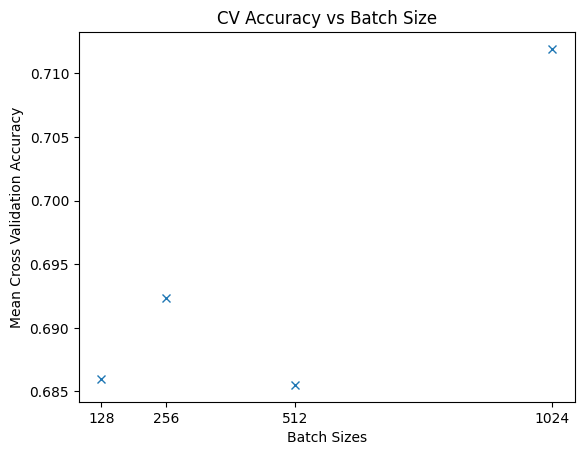

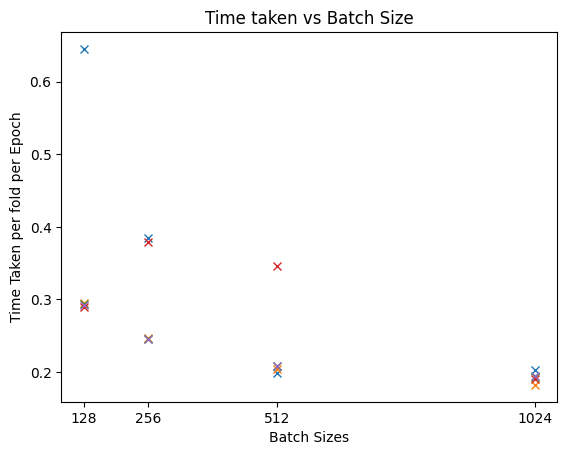

In [10]:
# YOUR CODE HERE
def scatterplot_this(cv_acc, batch_sizes, title):
    fig = plt.figure()
    plt.plot(batch_sizes, cv_acc, marker='x', linestyle='None')
    plt.xticks(batch_sizes)
    plt.xlabel('Batch Sizes')
    if "Accuracy" in title:
        plt.ylabel('Mean Cross Validation Accuracy')
        plt.title("CV Accuracy vs Batch Size")
    else:
        plt.ylabel('Time Taken per fold per Epoch')
        plt.title("Time taken vs Batch Size")
    plt.show()

print(f"CV_acc:\n{cross_validation_accuracies}")
print(f"CV Time taken:\n{cross_validation_times}")
# cv_acc = np.mean(cross_validation_accuracies, axis=1)
scatterplot_this(cross_validation_accuracies, batch_sizes, "Accuracy")
scatterplot_this(cross_validation_times, batch_sizes, "Timing")

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [11]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Mean Cross-Validation Accuracy': cross_validation_accuracies,
                #    'Last Epoch Time': cross_validation_times
                  })
for timing in range(len(cross_validation_times)):
    for fold in range(5):
        df.loc[timing, f'Epoch Time for Fold {fold + 1}'] = cross_validation_times[timing][fold]
df

,Batch Size,Mean Cross-Validation Accuracy,Epoch Time for Fold 1,Epoch Time for Fold 2,Epoch Time for Fold 3,Epoch Time for Fold 4,Epoch Time for Fold 5
0,128,0.685981,0.644902,0.295559,0.294253,0.289307,0.292244
1,256,0.692380,0.384328,0.247329,0.245171,0.378916,0.245730
2,512,0.685507,0.199292,0.204984,0.208469,0.346141,0.207848
3,1024,0.711933,0.203393,0.182401,0.192863,0.190098,0.194553


In [12]:
# YOUR CODE HERE
optimal_batch_size = 1024
reason = """
From the graphs and dataframe above, we can see that the Accuracy is the highest when the batch size is 1024.
We can also observe that the training time is lowest for 1024.

Considering that early stopping was implemented, the training stops earlier the smaller the batch size.
For example, batch size = 128's early stop occurs in the 10th epoch - 40th epoch range.
Batch size = 256's early stop occurs in the 48th epoch - 57th epoch range.
Batch size = 512's early stop occurs in the 43th epoch - 93th epoch range.
Batch size 1024 does not incur early stop.

We can infer that the batch size affects the value of the loss, where if the batch size is smaller,
it tends to increase the validation loss after a few rounds of epochs.
Whereas if the batch size is larger, the validation loss tend to not exceed the patience limit of early stopping,
which means the model would not overfit.

Looking at the accuracy of the model for each batch size, batch size = 1024 results in the highest accuracy,
as well as very short timings as well.

Therefore, I would pick 1024 as the batch size.
"""